# Model Selection for Smart Peak Splits

This notebook's objective is to select the model that will perform the desired predictions with the highest accuracy, once chosen, the model will be saved for the main pipeline at `orchestrator.py`

## Pipeline Overview

### Training Phase
1. **Data Collection**: GPX files are placed in `data/raw/` folder
2. **Feature Extraction**: Run `orchestrator.py` to parse GPX files and extract features (splits with distance, elevation, HR, pace, time)
3. **Model Training**: Train models on processed files from `data/processed/`
4. **Model Selection**: Evaluate and select the best performing model
5. **Save Model**: Save the selected model for inference

### Prediction Phase (After Training)
1. **Input**: New GPX file from user
2. **Parse GPX**: Extract splits data (distance, elevation, HR if available)
3. **Model Inference**: Predict for each split:
   - Time (seconds)
   - Average Pace (min/km)
   - Average HR (bpm)
4. **Output**: CSV with predicted splits performance

## Setup

Before proceeding, ensure to run `orchestrator.py` and that GPX files are available in the `data/raw/` folder. You will have processed files in `data/processed/` after running the orchestrator. The processed files are the ones that will be used for training and validating the model.

Please check the processed file sample at `data/samples/activity_20738496042_splits_sample.csv`

**Note**: There will be a sampling with 5 GPX files, those are supposed to be yours :)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import glob

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler
import pickle

## 1. Cargar y Preparar Datos

In [2]:
csv_folder = '../data/processed'

csv_files = glob.glob(os.path.join(csv_folder, '*.csv'))
print(f"Archivos encontrados: {len(csv_files)}\n")

if csv_files:
    first_file = csv_files[0]
    print(f"Inspeccionando: {os.path.basename(first_file)}")
    df_sample = pd.read_csv(first_file)
    print(f"\nColumnas: {df_sample.columns.tolist()}")
    print(f"\nPrimeras filas:")
    print(df_sample.head())

Archivos encontrados: 21

Inspeccionando: activity_17859577652_splits.csv

Columnas: ['Lap', 'Time', 'Distance', 'Avg Pace', 'Avg HR', 'Total Ascent', 'Total Descent']

Primeras filas:
   Lap      Time Distance Avg Pace  Avg HR Total Ascent Total Descent
0    1  00:21:29    1000m    21:28     105         191m            0m
1    2  00:28:32    1001m    28:29     118         240m           13m
2    3  00:27:11    1000m    27:10     108         213m           17m
3    4  00:23:09    1000m    23:08     113         230m           20m
4    5  00:26:21    1000m    26:20     114         211m           30m


In [3]:
csv_folder = '../data/processed'

all_data = []

for csv_file in glob.glob(os.path.join(csv_folder, '*.csv')):
    print(f"Cargando: {os.path.basename(csv_file)}")
    df = pd.read_csv(csv_file)
    
    df_mapped = pd.DataFrame()
    df_mapped['split_km'] = df['Lap']
    
    df_mapped['distance'] = df['Distance'].str.replace('m', '').astype(float) / 1000
    
    def parse_pace(pace_str):
        if pd.isna(pace_str):
            return np.nan
        parts = pace_str.split(':')
        return int(parts[0]) + int(parts[1]) / 60
    
    df_mapped['pace'] = df['Avg Pace'].apply(parse_pace)
    
    df_mapped['avg_hr'] = df['Avg HR']
    
    df_mapped['elevation_gain'] = df['Total Ascent'].str.replace('m', '').astype(float)
    df_mapped['elevation_loss'] = df['Total Descent'].str.replace('m', '').astype(float)
    
    df_mapped['cumulative_elevation_gain'] = df_mapped['elevation_gain'].cumsum()
    df_mapped['gradient'] = ((df_mapped['elevation_gain'] - df_mapped['elevation_loss']) / 
                              (df_mapped['distance'] * 1000 + 1e-6)) * 100
    
    all_data.append(df_mapped)

combined_df = pd.concat(all_data, ignore_index=True)

print(f"\nTotal splits cargados: {len(combined_df)}")
print(f"Columnas: {combined_df.columns.tolist()}")
print(f"Archivos procesados: {len(all_data)}")
print(f"\nPrimeras filas:")
combined_df.head()

Cargando: activity_17859577652_splits.csv
Cargando: activity_18170941049_splits.csv
Cargando: activity_18225716672_splits.csv
Cargando: activity_18551246758_splits.csv
Cargando: activity_18552267083_splits.csv
Cargando: activity_18683086473_splits.csv
Cargando: activity_18857599586_splits.csv
Cargando: activity_19095548271_splits.csv
Cargando: activity_19166015827_splits.csv
Cargando: activity_19302866302_splits.csv
Cargando: activity_19372812796_splits.csv
Cargando: activity_19515852689_splits.csv
Cargando: activity_20013791377_splits.csv
Cargando: activity_20090461114_splits.csv
Cargando: activity_20314363393_splits.csv
Cargando: activity_20387932202_splits.csv
Cargando: activity_20395619433_splits.csv
Cargando: activity_20600745436_splits.csv
Cargando: activity_20669495648_splits.csv
Cargando: activity_20738496042_splits.csv
Cargando: activity_20807142558_splits.csv

Total splits cargados: 514
Columnas: ['split_km', 'distance', 'pace', 'avg_hr', 'elevation_gain', 'elevation_loss', '

,split_km,distance,pace,avg_hr,elevation_gain,elevation_loss,cumulative_elevation_gain,gradient
0,1,1.000,21.466667,105,191.0,0.0,191.0,19.100000
1,2,1.001,28.483333,118,240.0,13.0,431.0,22.677323
2,3,1.000,27.166667,108,213.0,17.0,644.0,19.600000
3,4,1.000,23.133333,113,230.0,20.0,874.0,21.000000
4,5,1.000,26.333333,114,211.0,30.0,1085.0,18.100000


## 2. Feature Engineering y Creación de Secuencias

In [4]:
sequence_length = 5

feature_columns = ['elevation_gain', 'elevation_loss', 'distance', 'cumulative_elevation_gain', 'gradient']
target_columns = ['pace', 'avg_hr']

X = combined_df[feature_columns].values
y = combined_df[target_columns].values

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

print(f"Shape de X: {X_scaled.shape}")
print(f"Shape de y: {y_scaled.shape}")

Shape de X: (514, 5)
Shape de y: (514, 2)


In [5]:
def create_sequences(X, y, sequence_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - sequence_length):
        X_seq.append(X[i:i + sequence_length])
        y_seq.append(y[i + sequence_length])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, sequence_length)

print(f"Shape de X_seq: {X_seq.shape}")
print(f"Shape de y_seq: {y_seq.shape}")

Shape de X_seq: (509, 5, 5)
Shape de y_seq: (509, 2)


## 3. División Train/Validation

In [6]:
split_idx = int(len(X_seq) * 0.8)

X_train = X_seq[:split_idx]
y_train = y_seq[:split_idx]
X_val = X_seq[split_idx:]
y_val = y_seq[split_idx:]

print(f"Train samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")

Train samples: 407
Validation samples: 102


## 4. Construcción del Modelo LSTM

In [10]:
model = Sequential()

model.add(LSTM(64, activation='tanh', return_sequences=True, input_shape=(sequence_length, len(feature_columns))))
model.add(Dropout(0.3))

model.add(LSTM(32, activation='tanh', return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(2, activation='linear'))

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 5, 64)          │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,586 (123.38 KB)

 Trainable params: 31,522 (123.13 KB)

 Non-trainable params: 64 (256.00 B)

## 5. Entrenamiento

In [11]:
os.makedirs('models', exist_ok=True)

early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('models/best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

Epoch 1/100
 1/13 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - loss: 4.2288 - mae: 1.5646
Epoch 1: val_loss improved from None to 0.93895, saving model to models/best_model.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 1.9653 - mae: 1.0774 - val_loss: 0.9390 - val_mae: 0.7770
Epoch 2/100
 1/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.6834 - mae: 0.9756
Epoch 2: val_loss improved from 0.93895 to 0.93761, saving model to models/best_model.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3181 - mae: 0.9011 - val_loss: 0.9376 - val_mae: 0.7792
Epoch 3/100
 1/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.8690 - mae: 0.7452
Epoch 3: val_loss did not improve from 0.93761
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0756 - mae: 0.8309 - val_loss: 0.9453 - val_mae: 0.7849
Epoch 4/100
 1/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.2724 - mae: 0.8937
Epoch 4: val_loss did not improve from 0.93761
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9873 - mae: 0.7848 - val_loss: 0.959

## 6. Visualización del Entrenamiento

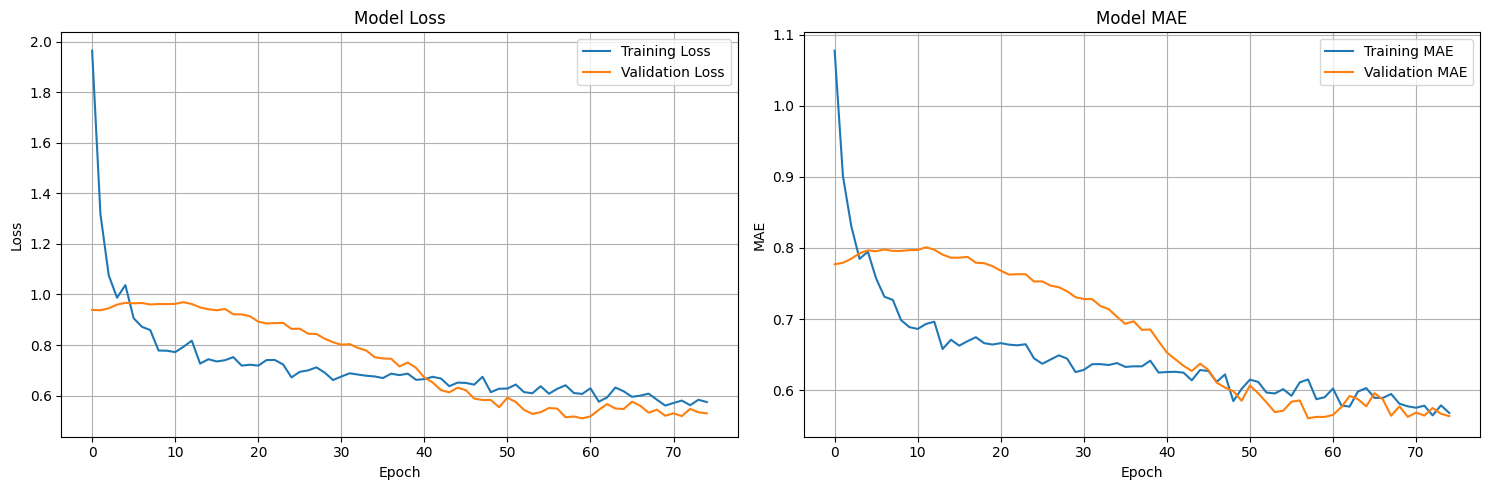

In [12]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('models/training_history.png')
plt.show()

## 7. Evaluación

In [13]:
results = model.evaluate(X_val, y_val, verbose=1)

print(f"\nValidation Loss: {results[0]:.4f}")
print(f"Validation MAE: {results[1]:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5096 - mae: 0.5625 

Validation Loss: 0.5096
Validation MAE: 0.5625


In [14]:
predictions = model.predict(X_val[:10])
predictions_original = scaler_y.inverse_transform(predictions)
y_val_original = scaler_y.inverse_transform(y_val[:10])

comparison_df = pd.DataFrame({
    'Real Pace': y_val_original[:, 0],
    'Pred Pace': predictions_original[:, 0],
    'Real HR': y_val_original[:, 1],
    'Pred HR': predictions_original[:, 1]
})

print("\nPrimeras 10 predicciones vs reales:")
comparison_df

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step

Primeras 10 predicciones vs reales:


,Real Pace,Pred Pace,Real HR,Pred HR
0,51.983333,36.074520,104.0,110.037689
1,48.233333,37.674702,104.0,111.497925
2,47.733333,36.103428,94.0,113.076996
3,29.850000,20.873335,89.0,120.595703
4,23.250000,13.932750,95.0,128.476883
5,18.550000,15.163866,96.0,123.422455
6,15.016667,16.559387,95.0,119.126526
7,18.716667,16.462641,88.0,114.770226
8,17.500000,19.214308,96.0,105.397842
9,12.883333,22.732502,97.0,95.955086


## 8. Guardar Modelo y Scalers

In [15]:
model.save('models/smart_peak_model.keras')

with open('models/scalers.pkl', 'wb') as f:
    pickle.dump({
        'scaler_X': scaler_X,
        'scaler_y': scaler_y,
        'sequence_length': sequence_length,
        'feature_columns': feature_columns,
        'target_columns': target_columns
    }, f)

print("Modelo guardado en: models/smart_peak_model.keras")
print("Scalers guardados en: models/scalers.pkl")

Modelo guardado en: models/smart_peak_model.keras
Scalers guardados en: models/scalers.pkl
